In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

# AIM
## To classify the images into 
### F Fatty
### G Fatty-glandular
### D Dense-glandular

# Validation Strategy:

## Train Data Size= 0.7*Total_Data
## Validation Data Size= 0.21* Total_Data
## Test Data Size= 0.09 * Total_Data

# Augmentaions Used:
## Each Image is rotated through 45 angles


In [2]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

All modules have been imported


In [3]:
info=pd.read_csv("../input/mias-mammography/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info.SEVERITY.fillna(0)

0      B
1      B
2      0
3      0
4      B
      ..
325    0
326    0
327    0
328    0
329    0
Name: SEVERITY, Length: 330, dtype: object

<AxesSubplot:ylabel='CLASS'>

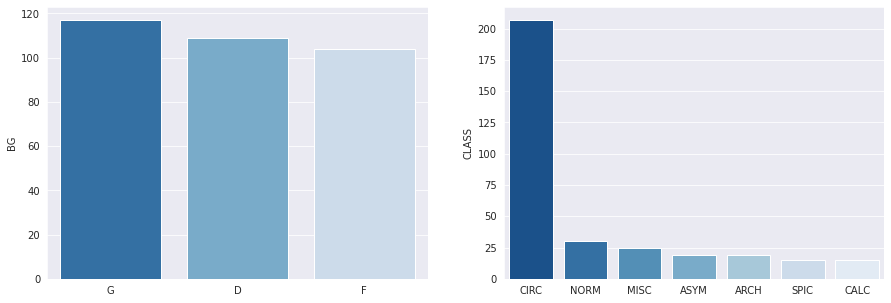

In [4]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=info.BG.unique(),y=info.BG.value_counts(),palette='Blues_r',ax=ax1)
sns.barplot(x=info.CLASS.unique(),y=info.CLASS.value_counts(),palette='Blues_r',ax=ax2)


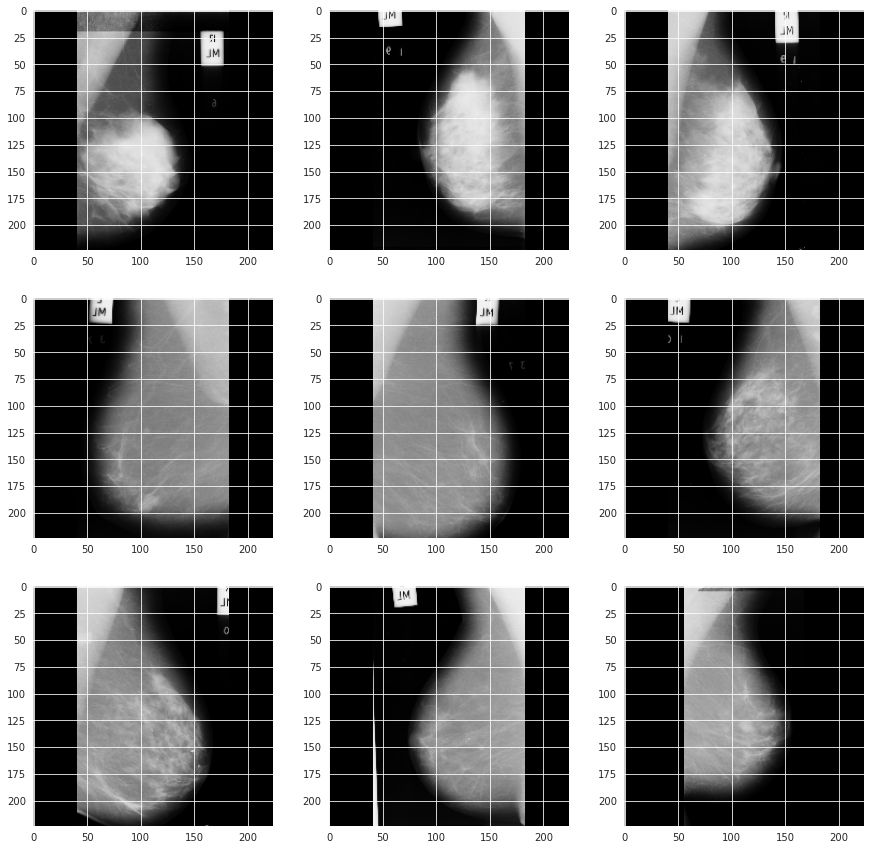

In [5]:
from PIL import Image
import glob
x= []
for filename in sorted(glob.glob("../input/mias-mammography/all-mias/*.pgm")): 
    img=cv2.imread(filename)
    img =cv2.resize(img,(224, 224))
    x.append(img)
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

In [6]:
# Image Augmentation
no_angles = 360
url = '/kaggle/input/mias-mammography/all-mias/'

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')

In [7]:
# train_test_split_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# val_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# test_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
def read_image():
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            img = cv2.resize(img, (224,224))
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) 
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)


In [8]:
import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))    

def read_lable():
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>1:
            if (words[1] == 'G'):
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 2
            if (words[1] == 'D'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 1
            if (words[1] == 'F'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 0
            
    return (info)

In [9]:
import numpy as np
lable_info=read_lable()
image_info=read_image()
ids=lable_info.keys() 
#del lable_info['Truth-Data:']
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,3)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

Reading images
10143 3042 1305


In [10]:
#Callbacks
c2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
nClasses=3

# DenseNet-201

In [11]:
base_Neural_Net= DenseNet201(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

74842112/74836368 [==============================] - 0s 0us/step


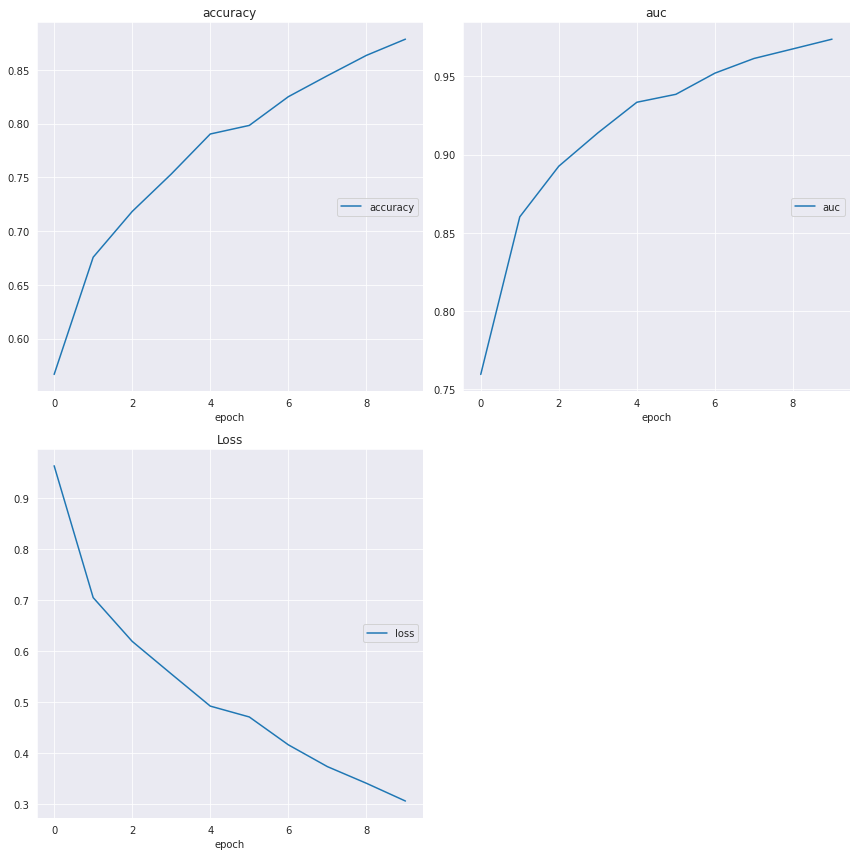

accuracy
	accuracy         	 (min:    0.567, max:    0.879, cur:    0.879)
auc
	auc              	 (min:    0.759, max:    0.974, cur:    0.974)
Loss
	loss             	 (min:    0.306, max:    0.963, cur:    0.306)


In [12]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [13]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 15s 64ms/step - loss: 0.4743 - accuracy: 0.8149 - auc: 0.9428


[0.47429323196411133, 0.814924418926239, 0.9427854418754578]

In [14]:
print("Performance Report:")
y_pred9=model.predict_classes(x_test)
y_test9=[np.argmax(x) for x in y_test]
y_pred_prb9=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test9, y_pred9),4))
print('Precision score is :', np.round(metrics.precision_score(y_test9, y_pred9, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test9,y_pred9, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test9, y_pred9, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test9, y_pred_prb9,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test9, y_pred9,target_names=target))

Performance Report:
Accuracy score is : 0.8031
Precision score is : 0.8061
Recall score is : 0.8031
F1 Score is : 0.8039
ROC AUC Score is : 0.9426
		Classification Report:
               precision    recall  f1-score   support

           G       0.88      0.87      0.87       392
           F       0.83      0.77      0.80       461
           D       0.72      0.78      0.75       452

    accuracy                           0.80      1305
   macro avg       0.81      0.81      0.81      1305
weighted avg       0.81      0.80      0.80      1305

